Copy-paste the contents of this notebook at the beginning of every other notebook in this project.

## Variable hyperparameters

In [1]:
# Fixed length of list to be sorted
LIST_LENGTH = 23

# Size of vocabulary
D_VOCAB = 7

# Should lists have repetitions?
ALLOW_REPETITIONS = True

# Attention only? (False -> model includes MLPs)
ATTN_ONLY = True
# ATTN_ONLY = False

# Model dimensions
N_LAYERS = 1
N_HEADS = 1
D_MODEL = 128
D_HEAD = 32
D_MLP = None

if ATTN_ONLY:
    D_MLP = None

# Default batch size
DEFAULT_BATCH_SIZE = 128

## Prelude

### Install and import

In [2]:
try:
    import transformer_lens
except:
    !pip install git+https://github.com/neelnanda-io/TransformerLens
    !pip install circuitsvis

/Users/randyardywibowo/miniconda3/envs/lit/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from __future__ import annotations
from dataclasses import dataclass, field
from datetime import datetime as dt
from itertools import repeat
import os
import pickle
import random
from typing import cast, Generator, Literal

import circuitsvis as cv
from fancy_einsum import einsum
from matplotlib import pyplot as plt
import numpy as np
import torch
from torch import nn, tensor, Tensor, TensorType as TT
from torch.nn import functional as F
from transformer_lens import HookedTransformerConfig, HookedTransformer
from tqdm import tqdm
from typing_extensions import Self

cv.examples.hello("You")

### Invariable hyperparameters

In [4]:
# DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DEVICE = "mps"
print(f"{DEVICE = }")

# Seeds to generate training, validation, and test data
TRAIN_SEED = 42
VAL_SEED = 66
TEST_SEED = 1729

# Context length: [start, *(unsorted_)list_length, mid, *(sorted_)list_length]
N_CTX = 2 * LIST_LENGTH + 2

# "Real" tokens range from 0 to D_VOCAB - 2 (non-inclusive)
VOCAB_MIN_ID = 0
VOCAB_MAX_ID = D_VOCAB - 2

# START token is D_VOCAB - 2 and MID token is D_VOCAB - 1
START_TOKEN_ID = VOCAB_MAX_ID
MID_TOKEN_ID = D_VOCAB - 1

DEVICE = 'mps'


### Data generator and datasets

In [5]:
import time
import torch
from torch.utils.data import TensorDataset, DataLoader, random_split
from itertools import combinations

vocab_list = list(range(VOCAB_MIN_ID, VOCAB_MAX_ID))

def map_integers_to_subsets(lst):
    subset_map = {}
    # Create subsets for all lengths
    for i in range(len(lst) + 1):
        for subset in combinations(lst, i):
            # Convert subset to list (because combinations returns tuples)
            subset_map[len(subset_map)] = list(subset)
    return subset_map

subset_map = map_integers_to_subsets(vocab_list)
subset_map.pop(0)

def generate_unique_list(total_size: int) -> torch.Tensor:
    # Generate a list of unique sequences
    start_time = time.time()
    unique_sequences = set()
    while len(unique_sequences) < total_size:
        if ALLOW_REPETITIONS:
            # Generate random number between 0 and 2
            random_number = random.choices(list(subset_map.keys()), k=1)[0]
            random_subset = subset_map[random_number]
            
            sequence = tuple(random.choices(random_subset, k=LIST_LENGTH))
            
            # if random_number == 0:
            #     sequence = tuple(torch.randint(VOCAB_MIN_ID, VOCAB_MAX_ID, (LIST_LENGTH,)).tolist())
            # elif random_number == 1:
            #     sequence = tuple(random.choices([0, 1], k=LIST_LENGTH))
            # elif random_number == 2:
            #     sequence = tuple(random.choices([0, 2], k=LIST_LENGTH))
            # elif random_number == 3:
            #     sequence = tuple(random.choices([1, 2], k=LIST_LENGTH))
        else:
            sequence = tuple(random.sample(range(VOCAB_MIN_ID, VOCAB_MAX_ID), k=LIST_LENGTH))
        unique_sequences.add(sequence)
        
        # Stop after 60 seconds
        if time.time() - start_time > 60:
            break  # Exit the loop

    # Convert to tensor and move to the correct DEVICE
    return torch.tensor(list(unique_sequences), dtype=torch.int32)

def process_data(data: torch.Tensor) -> torch.Tensor:
    # Sort the data
    data_sorted = torch.sort(data, dim=1).values
    # Add START tokens
    data_start = START_TOKEN_ID * torch.ones(data.size(0), 1, dtype=torch.int32)
    # Add MID tokens
    data_mid = MID_TOKEN_ID * torch.ones(data.size(0), 1, dtype=torch.int32)
    # Concatenate all parts
    return torch.cat((data_start, data, data_mid, data_sorted), dim=1)

# Set the seeds
torch.manual_seed(TRAIN_SEED)
data = generate_unique_list(2_000_000 + 200_000)  # extra for validation and test

# if not ALLOW_REPETITIONS:
#     # Generate the complete list of unique sequences
#     data = generate_unique_list(1_000_000 + 200_000)  # extra for validation and test
# else:
#     # If repetitions are allowed, just generate a large random tensor
#     data = torch.randint(VOCAB_MIN_ID, VOCAB_MAX_ID, (1_200_000, LIST_LENGTH), dtype=torch.int32)

# Process the data with start, mid tokens and sorted sequences
full_data = process_data(data)
full_data = full_data.long()

num_samples = full_data.size(0)

In [6]:
# Define the length of splits for train, validation, and test sets
train_length = num_samples * 8 // 10
val_length = num_samples * 1 // 10
test_length = num_samples - train_length - val_length

# Split the data into training, validation, and test sets
train_data, val_data, test_data = random_split(
    full_data, [train_length, val_length, test_length],
    generator=torch.Generator().manual_seed(42)  # for reproducibility
)

# Create DataLoaders for each set
# Wrap the actual data in a TensorDataset
train_loader = DataLoader(TensorDataset(train_data.dataset[train_data.indices]), batch_size=DEFAULT_BATCH_SIZE, shuffle=True)
val_loader = DataLoader(TensorDataset(val_data.dataset[val_data.indices]), batch_size=1024, shuffle=True)
test_loader = DataLoader(TensorDataset(test_data.dataset[test_data.indices]), batch_size=1024, shuffle=True)

In [7]:
num_samples

2200000

In [8]:
START_TOKEN_ID

5

In [9]:
next(iter(test_loader))[0][0]

tensor([5, 3, 4, 4, 2, 2, 3, 2, 3, 4, 4, 4, 2, 4, 3, 2, 2, 2, 3, 4, 2, 2, 3, 2,
        6, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4])

### Loss function

In [10]:
def loss_fn(
    logits: Tensor, # [batch, pos, d_vocab] 
    tokens: Tensor, # [batch, pos] 
    return_per_token: bool = False
) -> Tensor: # scalar
    """Mean cross-entropy between tokens in the sorted list part of the 
    sequence (last `LIST_LENGTH`) and model's predictions about them.
    """
    sorted_start_pos = LIST_LENGTH + 2
    logits = logits[:, (sorted_start_pos-1):-1]
    tokens = tokens[:, sorted_start_pos : None]
    log_probs = logits.log_softmax(-1)
    correct_log_probs = log_probs.gather(-1, tokens[..., None])[..., 0]
    if return_per_token:
        return -correct_log_probs
    return -correct_log_probs.mean()

### Accuracy and validation

In [63]:
def get_diff_row_inds(
    a: Tensor, # [dim1, dim2]
    b: Tensor  # [dim1, dim2]
) -> Tensor:   # [dim1]
    """Find indices of rows where a and b differ"""
    assert a.shape == b.shape
    return ((a == b).prod(dim=1) == 0).nonzero(as_tuple=True)[0]

def acc_fn(
    logits: Tensor, # [batch, pos, d_vocab]
    tokens: Tensor, # [batch, pos]
    per: Literal["token", "sequence"] = "sequence"
) -> float:
    """Compute accuracy as percentage of correct predictions"""
    assert per in ("token", "sequence")
    sorted_start_pos = LIST_LENGTH + 2
    # Get logits of predictions for position
    logits = logits[:, (sorted_start_pos-1):-1]
    preds = logits.argmax(-1).to(tokens.device)
    tokens = tokens[:, sorted_start_pos:]
    
    print(sorted_start_pos)
    print(preds)
    print(tokens)
    
    if per == "sequence":
        return (preds == tokens).prod(dim=1).float().mean().item()
    return (preds == tokens).float().mean().item()

def validate(
    model: HookedTransformer, 
    data: Tensor, # [batch, pos]
    per: Literal["token", "sequence"] = "sequence"
) -> float:
    """Test this model on `data`"""
    logits = model(data)
    acc = acc_fn(logits, tokens=data, per=per)
    return acc

def show_mispreds(
    model: HookedTransformer, 
    data: Tensor # [batch, pos]
) -> None:
    """Test this model on `data` and print mispredictions"""
    logits = model(data)
    sorted_start_pos = LIST_LENGTH + 2
    logits = logits[:, (sorted_start_pos-1):-1]
    tokens = data[:, sorted_start_pos:].cpu()
    preds = logits.argmax(-1).cpu()
    mispred_inds = get_diff_row_inds(tokens, preds)
    for i in mispred_inds:
        print(f"[{i}] {tokens[i].numpy().tolist()} | {preds[i].numpy().tolist()}")
    print(f"{len(mispred_inds)}/{len(preds)} ({len(mispred_inds) / len(preds) :.2%})")

## Training

### Model

In [12]:
cfg = HookedTransformerConfig(
    d_model=D_MODEL,
    n_layers=N_LAYERS,
    n_heads=N_HEADS,
    d_head=D_HEAD,
    n_ctx=N_CTX,
    d_vocab=D_VOCAB,
    act_fn="relu",
    seed=42,
    device=DEVICE,
    attn_only=ATTN_ONLY
)
model = HookedTransformer(cfg, move_to_device=True)


In [13]:
# model.pos_embed.W_pos.data[:] = 0
# model.pos_embed.W_pos.requires_grad = False

### Training setup

In [14]:
@dataclass(frozen=True)
class TrainingHistory:
    losses: list[float]
    train_accuracies: list[float]
    val_accuracies: list[float]

def converged(val_accs: list[float], n_last: int = 10) -> bool:
    return cast(bool, (tensor(val_accs[-n_last:]) == 1).all().item())

# Number of epochs
# n_epochs = 20000
n_epochs = 2500

# Optimization
lr = 1e-3
betas = (.9, .999)
optim = torch.optim.AdamW(model.parameters(), lr=lr, betas=betas)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, "min", patience=100)

# Training data generator
def train_model(model: HookedTransformer) -> TrainingHistory:
    losses = []
    train_accuracies = []
    val_accuracies = []
    
    train_gen = iter(train_loader)
    for epoch in range(n_epochs):
        
        try:
            tokens = next(train_gen)[0].to(device=DEVICE)
        except StopIteration:
            train_gen = iter(train_loader)
            tokens = next(train_gen)[0].to(device=DEVICE)
        
        logits = model(tokens)
        loss = loss_fn(logits, tokens)
        loss.backward()
        optim.step()
        optim.zero_grad()
        scheduler.step(loss)
        
        if epoch % 100 == 0:
            losses.append(loss.item())
            train_batch_acc = acc_fn(logits, tokens)
            
            val_data = next(iter(val_loader))[0].to(device=DEVICE)
            val_acc = validate(model, val_data)
            val_loss = loss_fn(model(val_data), val_data)

            train_accuracies.append(train_batch_acc)
            val_accuracies.append(val_acc)
            print(
                f"Epoch {epoch}/{n_epochs} ({epoch / n_epochs:.0%}) : "
                f"loss = {loss.item():.4f}; {train_batch_acc=:.3%}; "
                f"{val_acc=:.3%}; lr={scheduler._last_lr[0]}" #type:ignore
            )
            # If last 10 recorded val_accuracies are 100%
            if converged(val_accuracies):
                print(f"\nAchieved consistent perfect validation accuracy after {epoch} epochs")
                break
    return TrainingHistory(losses, train_accuracies, val_accuracies)

def load_model_state(model: HookedTransformer, filename: str) -> None:
    assert os.path.isdir("models"), "Make a directory `models` with model state dicts"
    if not filename.startswith("models/"):
        filename = f"models/{filename}"
    with open(filename, "rb") as f:
        state_dict = pickle.load(f)
    model.load_state_dict(state_dict)

In [15]:
train_gen = iter(train_loader)
next(train_gen)[0].shape

torch.Size([128, 48])

### Train or load model

In [44]:
history = train_model(model)

Epoch 0/2500 (0%) : loss = 0.0391; train_batch_acc=89.062%; val_acc=88.184%; lr=1.0000000000000004e-08
Epoch 100/2500 (4%) : loss = 0.0459; train_batch_acc=78.906%; val_acc=85.645%; lr=1.0000000000000004e-08
Epoch 200/2500 (8%) : loss = 0.0417; train_batch_acc=90.625%; val_acc=83.398%; lr=1.0000000000000004e-08
Epoch 300/2500 (12%) : loss = 0.0471; train_batch_acc=80.469%; val_acc=84.668%; lr=1.0000000000000004e-08
Epoch 400/2500 (16%) : loss = 0.0407; train_batch_acc=88.281%; val_acc=84.766%; lr=1.0000000000000004e-08
Epoch 500/2500 (20%) : loss = 0.0397; train_batch_acc=89.844%; val_acc=83.887%; lr=1.0000000000000004e-08
Epoch 600/2500 (24%) : loss = 0.0458; train_batch_acc=81.250%; val_acc=83.301%; lr=1.0000000000000004e-08
Epoch 700/2500 (28%) : loss = 0.0437; train_batch_acc=82.031%; val_acc=87.598%; lr=1.0000000000000004e-08
Epoch 800/2500 (32%) : loss = 0.0460; train_batch_acc=84.375%; val_acc=84.570%; lr=1.0000000000000004e-08
Epoch 900/2500 (36%) : loss = 0.0389; train_batch_a

In [45]:
# for name, param in model.named_parameters():
#     if not name.startswith("blocks"):
#         print(name, param.shape)

model

# for name, param in model.named_parameters():
#     print(name, param.shape)

# model.cfg.positional_embedding_type
# plt.plot(model.pos_embed.W_pos[-1].detach().cpu().numpy())
# plt.plot(model.pos_embed.W_pos[0].detach().cpu().numpy())


# model.pos_embed.W_pos.shape

# plt.plot(model.embed.W_E[0].detach().cpu().numpy())
# plt.plot(model.embed.W_E[1].detach().cpu().numpy())
# plt.plot(model.embed.W_E[2].detach().cpu().numpy())

HookedTransformer(
  (embed): Embed()
  (hook_embed): HookPoint()
  (pos_embed): PosEmbed()
  (hook_pos_embed): HookPoint()
  (blocks): ModuleList(
    (0): TransformerBlock(
      (ln1): LayerNorm(
        (hook_scale): HookPoint()
        (hook_normalized): HookPoint()
      )
      (attn): Attention(
        (hook_k): HookPoint()
        (hook_q): HookPoint()
        (hook_v): HookPoint()
        (hook_z): HookPoint()
        (hook_attn_scores): HookPoint()
        (hook_pattern): HookPoint()
        (hook_result): HookPoint()
      )
      (hook_attn_in): HookPoint()
      (hook_q_input): HookPoint()
      (hook_k_input): HookPoint()
      (hook_v_input): HookPoint()
      (hook_mlp_in): HookPoint()
      (hook_attn_out): HookPoint()
      (hook_mlp_out): HookPoint()
      (hook_resid_pre): HookPoint()
      (hook_resid_post): HookPoint()
    )
  )
  (ln_final): LayerNorm(
    (hook_scale): HookPoint()
    (hook_normalized): HookPoint()
  )
  (unembed): Unembed()
)

In [46]:
next(iter(val_loader))

[tensor([[5, 4, 4,  ..., 4, 4, 4],
         [5, 4, 1,  ..., 4, 4, 4],
         [5, 4, 2,  ..., 4, 4, 4],
         ...,
         [5, 4, 4,  ..., 4, 4, 4],
         [5, 0, 1,  ..., 3, 3, 3],
         [5, 1, 1,  ..., 3, 3, 3]])]

### Testing post-training

In [47]:
print("Validating on validation data:")
val_batch = next(iter(val_loader))[0]
val_acc = validate(model, val_batch)
print(f"\t{val_acc=:.3%}\n")
if val_acc < 1:
    show_mispreds(model, val_batch)

test_batch = next(iter(test_loader))[0]
print("\nValidating on test data:")
test_acc = validate(model, test_batch)
print(f"\t{test_acc=:.3%}\n")
if test_acc < 1:
    show_mispreds(model, test_batch)

Validating on validation data:
	val_acc=85.645%

[6] [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 3, 3, 3, 3, 3] | [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 3, 3, 3, 3, 3, 3]
[19] [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 3] | [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2]
[22] [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2] | [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2]
[23] [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1] | [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1]
[24] [0, 0, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4] | [0, 0, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4]
[27] [1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 4, 4, 4, 4, 4, 4, 4] | [1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 3, 4, 4, 4, 4, 4, 4, 4]
[29] [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

### Saving trained model

In [48]:
def save_model_state_dict(
    model: HookedTransformer, 
    filename: str | None = None
) -> None:
    if not os.path.isdir("models"):
        os.mkdir("models")
    if not filename:
        timestamp = dt.now().isoformat("T", "minutes").replace(":", "-")
        filename = f"model_state_dict_{timestamp}.pkl"
    with open(f"models/{filename}", "wb") as f:
        pickle.dump(model.state_dict(), f)

save_model_state_dict(model)

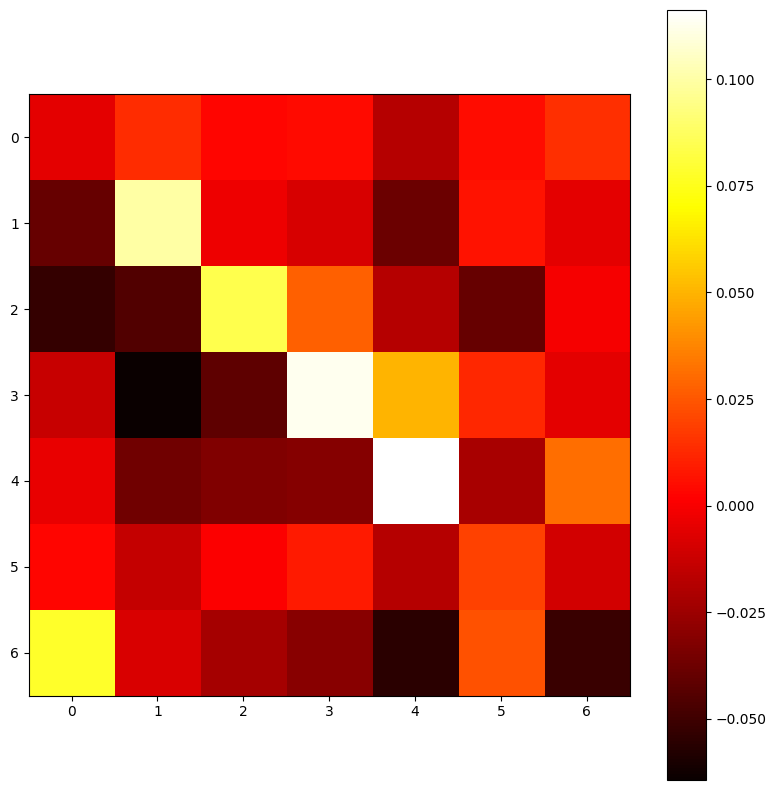

In [49]:
attn = model.blocks[0].attn
all_token_embeddings = model.embed(range(D_VOCAB))

embeddings_key = einsum("d_vocab d_model, n_heads d_model d_head -> n_heads d_vocab d_head", 
                        all_token_embeddings, attn.W_K) 
embeddings_query = einsum("d_vocab d_model, n_heads d_model d_head -> n_heads d_vocab d_head", 
                          all_token_embeddings, attn.W_Q) 

plt.rcParams['figure.figsize'] = [20, 10]
qk_circuit_attn_heatmap = einsum(
    "n_heads d_vocab_q d_head, n_heads d_vocab_k d_head -> ... d_vocab_q d_vocab_k", 
    embeddings_query, embeddings_key
    ).detach().cpu().numpy()
fig, ax = plt.subplots(figsize=(8, 8))
graph = ax.imshow(qk_circuit_attn_heatmap, cmap="hot", interpolation="nearest")
plt.colorbar(graph)
plt.tight_layout()

In [50]:
input_tokens = torch.Tensor([START_TOKEN_ID] + [0] * 5 + [1] * 5 + [MID_TOKEN_ID] + 5 * [0] + 5 * [1]).long().to(DEVICE)

In [51]:
input_tokens 
pos_embeds = model.pos_embed(input_tokens)

In [52]:
model.pos_embed.W_pos.shape

torch.Size([48, 128])

In [53]:
from typing import *
from transformer_lens import ActivationCache, HookedTransformer
from jaxtyping import Float
from circuitsvis.attention import attention_heads

def sharpen_probabilities(tensor, temperature):
    # Make sure the temperature is greater than 0 to avoid division by zero
    assert temperature > 0, "Temperature must be greater than 0"
    
    # Sharpen the probabilities
    sharpened = torch.pow(tensor, 1/temperature)
    
    # Renormalize the rows to sum to 1
    row_sums = sharpened.sum(dim=1).unsqueeze(1)
    normalized = sharpened / row_sums
    
    return normalized

def visualize_attention_patterns(
    heads: Union[List[int], int, Float[torch.Tensor, "heads"]],
    local_cache: ActivationCache,
    local_tokens: torch.Tensor,
    title: Optional[str] = "",
    max_width: Optional[int] = 1000,
    temp = 0.9
) -> str:
    # If a single head is given, convert to a list
    if isinstance(heads, int):
        heads = [heads]

    # Create the plotting data
    labels: List[str] = []
    patterns: List[Float[torch.Tensor, "dest_pos src_pos"]] = []

    # Assume we have a single batch item
    batch_index = 0

    for head in heads:
        # Set the label
        layer = head // model.cfg.n_heads
        head_index = head % model.cfg.n_heads
        labels.append(f"L{layer}H{head_index}")

        # Get the attention patterns for the head
        # Attention patterns have shape [batch, head_index, query_pos, key_pos]
        patterns.append(sharpen_probabilities(local_cache["attn", layer][batch_index, head_index], temp))

    # Convert the tokens to strings (for the axis labels)
    str_tokens = local_tokens.detach().cpu().numpy().astype(str).tolist()

    # Combine the patterns into a single tensor
    patterns: Float[torch.Tensor, "head_index dest_pos src_pos"] = torch.stack(
        patterns, dim=0
    )

    # Circuitsvis Plot (note we get the code version so we can concatenate with the title)
    plot = attention_heads(
        attention=patterns, tokens=str_tokens, attention_head_names=labels
    ).show_code()

    # Display the title
    title_html = f"<h2>{title}</h2><br/>"

    # Return the visualisation as raw code
    return f"<div style='max-width: {str(max_width)}px;'>{title_html + plot}</div>"

In [54]:
from IPython.display import HTML, IFrame

# input_tokens = torch.Tensor([START_TOKEN_ID] + [0] * 5 + [1] * 5 + [MID_TOKEN_ID] + 5 * [0] + 5 * [1]).long().to(DEVICE)

# list_to_sort = [1] * LIST_LENGTH // 2 + [0] * (LIST_LENGTH - (LIST_LENGTH // 2))
list_to_sort = [0] * 17 + [1] * 6
# list_to_sort = [0,1,1,0,1,0,2,3,4,5]
# list_to_sort = [0,1,2,3,4,5,6,7,8,9]
tokens = torch.Tensor([START_TOKEN_ID] + list_to_sort + [MID_TOKEN_ID] + sorted(list_to_sort)).long().to(DEVICE)

# tokens = next(train_gen)[0].to(device=DEVICE)[0]
print(tokens.shape)

# Run the model and cache all activations
original_logits, cache = model.run_with_cache(tokens)

positive_html = visualize_attention_patterns(
    [0],
    cache,
    tokens,
    f"What",
    temp=1
)


HTML(positive_html)

torch.Size([48])


In [55]:
next(iter(val_loader))[0][0].shape

torch.Size([48])

In [56]:
tokens = next(iter(val_loader))[0][0].to(device=DEVICE)

tokens = tokens[None, :]
val_acc = validate(model, tokens)
val_acc

1.0

In [57]:
tokens[0]

tensor([5, 3, 2, 2, 2, 3, 4, 1, 3, 1, 2, 2, 3, 2, 2, 2, 1, 3, 2, 1, 4, 4, 1, 1,
        6, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4, 4],
       device='mps:0')

In [58]:
model(tokens)[0].argmax(-1)[:-1]

tensor([4, 3, 2, 2, 2, 3, 4, 1, 3, 1, 2, 2, 3, 2, 2, 2, 1, 3, 2, 1, 2, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4, 4],
       device='mps:0')

In [59]:
model(tokens)[0].argmax(-1)[24:-1].cpu() == tokens[0][25:].cpu()

tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True])

In [60]:
from IPython.display import HTML, IFrame

# input_tokens = torch.Tensor([START_TOKEN_ID] + [0] * 5 + [1] * 5 + [MID_TOKEN_ID] + 5 * [0] + 5 * [1]).long().to(DEVICE)

# list_to_sort = [1] * LIST_LENGTH // 2 + [0] * (LIST_LENGTH - (LIST_LENGTH // 2))
# list_to_sort = [0] * 17 + [1] * 6
# list_to_sort = [0,1,1,0,1,0,2,3,4,5]
# list_to_sort = [0,1,2,3,4,5,6,7,8,9]
# tokens = torch.Tensor([START_TOKEN_ID] + list_to_sort + [MID_TOKEN_ID] + sorted(list_to_sort)).long().to(DEVICE)

# tokens = next(train_gen)[0].to(device=DEVICE)[0]
print(tokens.shape)

# Run the model and cache all activations
original_logits, cache = model.run_with_cache(tokens[0])

positive_html = visualize_attention_patterns(
    [0],
    cache,
    tokens[0],
    f"What",
    temp=1
)


HTML(positive_html)


torch.Size([1, 48])


torch.Size([1, 48])
torch.Size([7, 48])
tensor([[5, 3, 2, 2, 2, 3, 4, 1, 3, 1, 2, 2, 3, 2, 2, 2, 1, 3, 2, 1, 4, 4, 1, 1,
         6, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4, 4]],
       device='mps:0')


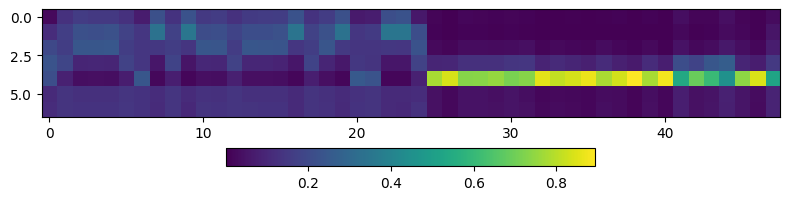

In [61]:
attn = model.blocks[0].attn
all_token_embeddings = model.input_to_embed(tokens)[0][0]

print(tokens.shape)

# attn.W_V.shape
OV_circuit_1 = (attn.W_V[0] @ attn.W_O[0])
OV_circuit_2 = model.unembed.W_U
OV_circuit_1.shape

out = (all_token_embeddings @ OV_circuit_1) @ OV_circuit_2

out = torch.softmax(out, dim=-1)
out = sharpen_probabilities(out, 1)

out = out.transpose(0,1)

print(out.shape)

plt.rcParams['figure.figsize'] = [20, 10]
fig, ax = plt.subplots(figsize=(8, 8))
graph = ax.imshow(out.detach().cpu().numpy(), cmap="viridis", interpolation="nearest")
cbar = plt.colorbar(graph, orientation='horizontal', shrink=0.5, pad=0.04)
plt.tight_layout()

print(tokens)


In [35]:
model.pos_embed(tokens)[0].shape

torch.Size([48, 128])

torch.Size([1, 48])
torch.Size([7, 48])
tensor([[5, 1, 1, 3, 1, 3, 3, 4, 3, 1, 4, 1, 1, 4, 3, 4, 3, 1, 1, 4, 4, 1, 1, 4,
         6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4]],
       device='mps:0')


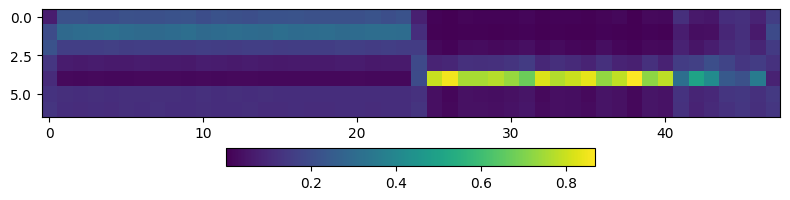

In [41]:
tokens = next(iter(val_loader))[0][0].to(device=DEVICE)

tokens = tokens[None, :]
val_acc = validate(model, tokens)

attn = model.blocks[0].attn
all_token_embeddings = model.pos_embed(tokens)[0]

print(tokens.shape)

# attn.W_V.shape
OV_circuit_1 = (attn.W_V[0] @ attn.W_O[0])
OV_circuit_2 = model.unembed.W_U
OV_circuit_1.shape

out = (all_token_embeddings @ OV_circuit_1) @ OV_circuit_2

out = torch.softmax(out, dim=-1)
out = sharpen_probabilities(out, 1)

out = out.transpose(0,1)

print(out.shape)

plt.rcParams['figure.figsize'] = [20, 10]
fig, ax = plt.subplots(figsize=(8, 8))
graph = ax.imshow(out.detach().cpu().numpy(), cmap="viridis", interpolation="nearest")
cbar = plt.colorbar(graph, orientation='horizontal', shrink=0.5, pad=0.04)
plt.tight_layout()

print(tokens)


25
tensor([[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 3]],
       device='mps:0')
tensor([[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]],
       device='mps:0')
0.0
torch.Size([48])
torch.Size([7, 48])
tensor([5, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        6, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
       device='mps:0')


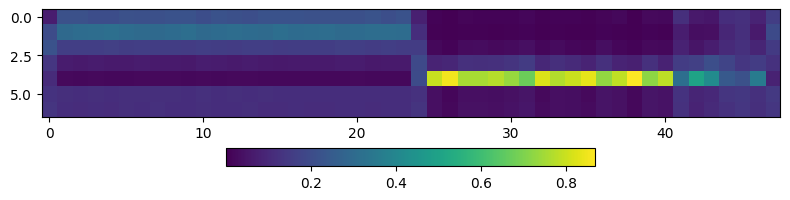

In [64]:
tokens = torch.Tensor([START_TOKEN_ID] + [3] * 23 + [MID_TOKEN_ID] + [3] * 23).long().to(DEVICE)
val_acc = validate(model, tokens[None, :])
print(val_acc)

attn = model.blocks[0].attn
all_token_embeddings = model.pos_embed(tokens)[0]
# all_token_embeddings = model.embed(tokens)

print(tokens.shape)

# attn.W_V.shape
OV_circuit_1 = (attn.W_V[0] @ attn.W_O[0])
OV_circuit_2 = model.unembed.W_U
OV_circuit_1.shape

out = (all_token_embeddings @ OV_circuit_1) @ OV_circuit_2

out = torch.softmax(out, dim=-1)
out = sharpen_probabilities(out, 1)

out = out.transpose(0,1)

print(out.shape)

plt.rcParams['figure.figsize'] = [20, 10]
fig, ax = plt.subplots(figsize=(8, 8))
graph = ax.imshow(out.detach().cpu().numpy(), cmap="viridis", interpolation="nearest")
cbar = plt.colorbar(graph, orientation='horizontal', shrink=0.5, pad=0.04)
plt.tight_layout()

print(tokens)
